#  CHE 614 course project final report (supporting information): Heat transfer behavior modeling in core-shell paraffin@Silica nanoparticles with Openpnm.
## Main content: shell thickness effect on effective thermal conductance in different temperature reigons
## Jinhe Zhang #20985826
As discussed at the beginning of the semester, this section supplements the heat transfer behavior of materials in different temperature ranges. The three situations are mainly analyzed, the inlet and outlet temperature is higher than the paraffin phase change temperature, the inlet and outlet temperature is lower than the paraffin phase change temperature, and the paraffin phase change temperature is between the inlet and outlet temperature.

## 1. Generating network

In [1]:
import numpy as np
import openpnm as op
import scipy as sp
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
shape = [10, 10, 10]
spacing = 1e-5
net = op.network.Cubic(shape=shape, spacing=spacing)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-08-25 19:55:09,358
------------------------------------------------------------


## 2. Adding geometry

In [3]:
geom = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)
geom['pore.diameter'] = np.random.rand(net.Np)*1e-5
mode = op.models.misc.from_neighbor_pores
geom['throat.diameter'] = mode(target=geom, prop='pore.diameter')

## 3. Adding phases

In [169]:
prf = op.phases.GenericPhase(network=net)
air = op.phases.Air(network=net)
Ka = air['pore.thermal_conductivity']   # air heat transfer coefficient
Kps = 0.4  #solid paraffin heat transfer coefficient
Kpl = 0.2  #liquid paraffin heat transfer coefficient
Ks = 0.27  #silica heat transfer coefficient

## 4. Adding physics

In [170]:
phys = op.physics.GenericPhysics(network=net, phase=prf, geometry=geom)
P12 = net['throat.conns']
D1 = geom['pore.diameter'][P12[:,0]]  # diameter of one pore/ paraffin core
D2 = geom['pore.diameter'][P12[:,1]]  # diameter of another pore/ paraffin core
R_T = geom['throat.diameter']/2  # radius of throat/ heat transfer channel
R_P = geom['pore.diameter']/2  # radius of pore/ paraffin core
R_w = spacing - D1/2 - D2/2  # the R_w means the distance between two paraffin sphere surfaces
Rs = 1.0E-06  # silica layer thickness
def gfunc(T, Kp):
        g_P = Kp*sp.pi*(R_P)**2/(R_P)
        g_th = np.zeros_like(R_T)              
        for i in range(len(R_w)):
            if R_w[i] - 2 * Rs > 0:  #means the air gap exist between two spheres
                R_sas = R_w - 2*Rs             
                g_T = np.mean(Ks)*sp.pi*(R_T[i])**2/(Rs)
                g_A = np.mean(Ka)*sp.pi*(R_T[i])**2/(R_sas[i])
                g_th[i] = (1/g_A + 2/g_T + 1/g_P[P12[i, 0]] + 1/g_P[P12[i, 1]])**-1
            else:   #means two spheres are connected
                g_T = np.mean(Ks)*sp.pi*(R_T[i])**2/(R_w[i])
                g_th[i] = (1/g_T + 1/g_P[P12[i, 0]] + 1/g_P[P12[i, 1]])**-1
        return g_th
phys['throat.thermal_conductance'] = gfunc(T=293.0, Kp=0.4)  #temporarily assuming all paraffin are in solid state

## 5. Performing fourier conduction
### 5.1. T_in and T_out are higher than phase chage temperature 

In [171]:
inlet = net.pores('left')  # set the inlet
outlet = net.pores('right')  # set the outlet
T_in = 353  # K, inlet temperature
T_out = 333  # K, outlet temperature
T_melting = 323  # K, paraffin melting temperature
fc = op.algorithms.FourierConduction(network=net)
fc.setup(phase=prf)
fc.set_value_BC(pores=inlet, values=T_in)
fc.set_value_BC(pores=outlet, values=T_out)
fc.run()

In [172]:
num = 5  # times of iterate
for x in range(num):
    T_p = fc['pore.temperature']
    K_prf = np.zeros_like(R_P)
    for i in range(len(T_p)):
        if T_p[i] > T_melting:
            K_prf[i] = Kpl
        else:
            K_prf[i] = Kps
    prf['pore.thermal_conductivity'] = K_prf
    phys['throat.thermal_conductance'] = gfunc(T = T_p, Kp=K_prf)
    fc = op.algorithms.FourierConduction(network=net)
    fc.setup(phase=prf)
    fc.set_value_BC(pores=inlet, values=T_in)
    fc.set_value_BC(pores=outlet, values=T_out)
    fc.run()

In [173]:
rate_inlet = fc.rate(pores=inlet)[0]
A = (shape[0] * shape[1])*(spacing**2)
L = shape[2]*spacing
k_eff = rate_inlet * L / (A * (T_in - T_out))
print("{0:.6E}".format(k_eff))

1.243735E-02


In [10]:
net.project.export_data(phases=[fc], filename='80to60_ls_prf', filetype='vtk')

------------------------------------------------------------
SOURCE     : openpnm.io.VTK.export_data 
TIME STAMP : 2022-08-25 20:04:26,300
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.io.VTK.export_data 
TIME STAMP : 2022-08-25 20:04:26,301
------------------------------------------------------------


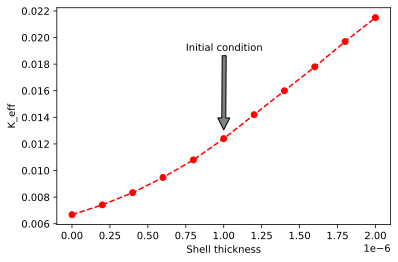

In [81]:
x=[0.00E+00, 2.00E-07,4.00E-07,6.00E-07,8.00E-07,1.00E-06,1.20E-06,1.40E-06,1.60E-06,1.80E-06,2.00E-06]
y=[6.68E-03, 7.42E-03, 8.34E-03, 9.48E-03, 1.08E-02, 1.24E-02, 1.42E-02, 1.60E-02, 1.78E-02, 1.97E-02, 2.15E-02]
plt.plot(x,y,color='r',marker='o',linestyle='dashed')
plt.xlabel('Shell thickness')
plt.ylabel('K_eff')
plt.annotate('Initial condition', xy=(1.00E-06,1.30E-02), xytext=(0.75E-06, 1.90E-02),
            arrowprops=dict(facecolor='grey', shrink=0.01),
            )
plt.show()

### 5.2. T_in and T_out are lower than phase chage temperature 

In [174]:
inlet = net.pores('left')  # set the inlet
outlet = net.pores('right')  # set the outlet
T_in = 313  # K, inlet temperature
T_out = 293  # K, outlet temperature
T_melting = 323  # K, paraffin melting temperature
fc = op.algorithms.FourierConduction(network=net)
fc.setup(phase=prf)
fc.set_value_BC(pores=inlet, values=T_in)
fc.set_value_BC(pores=outlet, values=T_out)
fc.run()

In [175]:
num = 5  # times of iterate
for x in range(num):
    T_p = fc['pore.temperature']
    K_prf = np.zeros_like(R_P)
    for i in range(len(T_p)):
        if T_p[i] > T_melting:
            K_prf[i] = Kpl
        else:
            K_prf[i] = Kps
    prf['pore.thermal_conductivity'] = K_prf
    phys['throat.thermal_conductance'] = gfunc(T = T_p, Kp=K_prf)
    fc = op.algorithms.FourierConduction(network=net)
    fc.setup(phase=prf)
    fc.set_value_BC(pores=inlet, values=T_in)
    fc.set_value_BC(pores=outlet, values=T_out)
    fc.run()

In [176]:
rate_inlet = fc.rate(pores=inlet)[0]
A = (shape[0] * shape[1])*(spacing**2)
L = shape[2]*spacing
k_eff = rate_inlet * L / (A * (T_in - T_out))
print("{0:.6E}".format(k_eff))

1.593873E-02


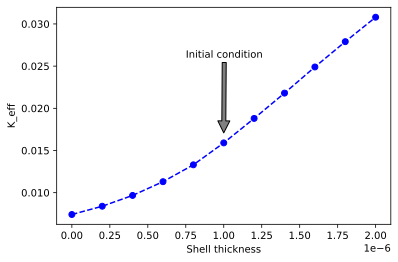

In [182]:
x=[0.00E+00, 2.00E-07,4.00E-07,6.00E-07,8.00E-07,1.00E-06,1.20E-06,1.40E-06,1.60E-06,1.80E-06,2.00E-06]
y=[7.41E-03, 8.39E-03, 9.67E-03, 1.13E-02, 1.33E-02, 1.59E-02, 1.88E-02, 2.18E-02, 2.49E-02, 2.79E-02, 3.08E-02]
plt.plot(x,y,color='b',marker='o',linestyle='dashed')
plt.xlabel('Shell thickness')
plt.ylabel('K_eff')
plt.annotate('Initial condition', xy=(1.00E-06,1.70E-02), xytext=(0.75E-06, 2.60E-02),
            arrowprops=dict(facecolor='grey', shrink=0.01),
            )
plt.show()

### 5.3. Phase change temperature is between T_in and T_out
This part has the same conditions in the final report. However, the network is randomly built, which makes the solution different from the final report.

In [177]:
inlet = net.pores('left')  # set the inlet
outlet = net.pores('right')  # set the outlet
T_in = 333  # K, inlet temperature
T_out = 313  # K, outlet temperature
T_melting = 323  # K, paraffin melting temperature
fc = op.algorithms.FourierConduction(network=net)
fc.setup(phase=prf)
fc.set_value_BC(pores=inlet, values=T_in)
fc.set_value_BC(pores=outlet, values=T_out)
fc.run()

In [178]:
num = 5  # times of iterate
for x in range(num):
    T_p = fc['pore.temperature']
    K_prf = np.zeros_like(R_P)
    for i in range(len(T_p)):
        if T_p[i] > T_melting:
            K_prf[i] = Kpl
        else:
            K_prf[i] = Kps
    prf['pore.thermal_conductivity'] = K_prf
    phys['throat.thermal_conductance'] = gfunc(T = T_p, Kp=K_prf)
    fc = op.algorithms.FourierConduction(network=net)
    fc.setup(phase=prf)
    fc.set_value_BC(pores=inlet, values=T_in)
    fc.set_value_BC(pores=outlet, values=T_out)
    fc.run()

In [179]:
rate_inlet = fc.rate(pores=inlet)[0]
A = (shape[0] * shape[1])*(spacing**2)
L = shape[2]*spacing
k_eff = rate_inlet * L / (A * (T_in - T_out))
print("{0:.6E}".format(k_eff))

1.409432E-02


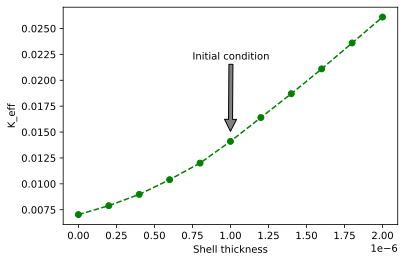

In [187]:
x=[0.00E+00, 2.00E-07,4.00E-07,6.00E-07,8.00E-07,1.00E-06,1.20E-06,1.40E-06,1.60E-06,1.80E-06,2.00E-06]
y=[7.03E-03, 7.89E-03, 8.98E-03, 1.04E-02, 1.20E-02, 1.41E-02, 1.64E-02, 1.87E-02, 2.11E-02, 2.36E-02, 2.61E-02]
plt.plot(x,y,color='green',marker='o',linestyle='dashed')
plt.xlabel('Shell thickness')
plt.ylabel('K_eff')
plt.annotate('Initial condition', xy=(1.00E-06,1.50E-02), xytext=(0.75E-06, 2.20E-02),
            arrowprops=dict(facecolor='grey', shrink=0.01),
            )
plt.show()

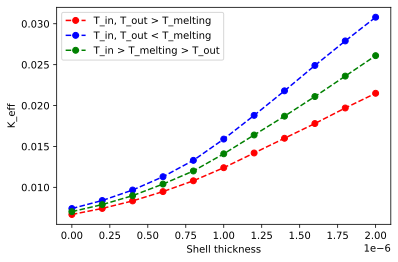

In [196]:
x=[0.00E+00, 2.00E-07,4.00E-07,6.00E-07,8.00E-07,1.00E-06,1.20E-06,1.40E-06,1.60E-06,1.80E-06,2.00E-06]
y1=[6.68E-03, 7.42E-03, 8.34E-03, 9.48E-03, 1.08E-02, 1.24E-02, 1.42E-02, 1.60E-02, 1.78E-02, 1.97E-02, 2.15E-02]
y2=[7.41E-03, 8.39E-03, 9.67E-03, 1.13E-02, 1.33E-02, 1.59E-02, 1.88E-02, 2.18E-02, 2.49E-02, 2.79E-02, 3.08E-02]
y3=[7.03E-03, 7.89E-03, 8.98E-03, 1.04E-02, 1.20E-02, 1.41E-02, 1.64E-02, 1.87E-02, 2.11E-02, 2.36E-02, 2.61E-02]
plt.plot(x,y1,color='red',marker='o',linestyle='dashed', label="T_in, T_out > T_melting")
plt.plot(x,y2,color='blue',marker='o',linestyle='dashed', label="T_in, T_out < T_melting")
plt.plot(x,y3,color='green',marker='o',linestyle='dashed', label="T_in > T_melting > T_out")
plt.xlabel('Shell thickness')
plt.ylabel('K_eff')
plt.legend(loc="best", fontsize=10)
plt.show()